## Laboratorio #1 – Detección de Pishing

#### Miembros
- Jennifer Toxcon 21276
- Fabian Juarez 21440

### Parte 1 – Ingeniería de características

In [196]:
##Importancion de librerias
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

In [197]:
## carga de datos
df = pd.read_csv("dataset_pishing.csv", sep = ",")

In [198]:
type(df)

pandas.core.frame.DataFrame

In [199]:
## verificacion de estructura de la data
n = int(input("Ingrese las filas que desea ver"))
df.head(n)

,url,status
0,http://www.crestonwood.com/router.php,legitimate
1,http://shadetreetechnology.com/V4/validation/a...,phishing
2,https://support-appleld.com.secureupdate.duila...,phishing
3,http://rgipt.ac.in,legitimate
4,http://www.iracing.com/tracks/gateway-motorspo...,legitimate


In [200]:
# Contar los valores únicos en la columna 'status'
status_counts = df['status'].value_counts()
print("Conteo de cada status:")
print(status_counts)

# Calcular los porcentajes
status_percentages = df['status'].value_counts(normalize=True) * 100
print("\nPorcentajes:")
print(status_percentages.round(2), "%")

Conteo de cada status:
status
legitimate    5715
phishing      5715
Name: count, dtype: int64

Porcentajes:
status
legitimate    50.0
phishing      50.0
Name: proportion, dtype: float64 %


Teniendo en cuenta lo anterior el dataset se encuentra balanceado.

### Derivación de características

¿Qué ventajas tiene el análisis de una URL contra el análisis de otros datos, cómo el tiempo
de vida del dominio, o las características de la página Web?

Nos ayuda a evitar que se tenga que llegar a realizar una descarga de la pagina y este puede poseer un virus o codigo malisioso que puede afectarlo.

Analizar una URL es rápido ya que solo es texto, mientras que al analizar la página completa o verificar el historial de dominio puede requerir más recursos y acceso a bases de datos externos, igualmente algunas páginas pueden bloquear el acceso de scarpers o herramientas de análisis, pero la URL se puede analizar sin necesidad de entrar al sitio web.

¿Qué características de una URL son más prometedoras para la detección de phishing?

El análisis de una URL es una herramienta efectiva para detectar sitios de phishing, ya que su estructura puede revelar patrones sospechosos sin necesidad de acceder al contenido de la página. 

- Los sitios de phishing suelen imitar dominios legítimos agregando palabras clave reconocidas como "login", "secure", "bank" etc.

- URLs que incluyen símbolos como @, %, -, _ en posiciones extrañas pueden estar tratando de ocultar su verdadero dominio.

- URLs con múltiples subdirectorios anidados pueden ser indicativas de una estructura diseñada para engañar al usuario.

- URLs extremadamente largas pueden ser un intento de ocultar información maliciosa dentro de parámetros.

- Cantidad de subdominios

- Redireccionamiento (poseer mas de una url)

### Funciones para extraer características de una URL

- Entropía de Shannon
    - Calcula la entropía de la URL para medir qué tan aleatoria es.
    - URLs generadas aleatoriamente suelen tener alta entropía.

- Entropía relativa
    - Normaliza la entropía de Shannon respecto a la longitud de la URL.
    - URLs de phishing tienden a ser más caóticas que las legítimas.

- Longitud total de la URL
    - Calcula la cantidad total de caracteres en la URL.
    - URLs largas suelen ser sospechosas.

- Número de subdominios
    - Cuenta los subdominios en la URL (separados por puntos .).
    - Un número alto puede indicar phishing (login.secure.paypal.com).

- Número de caracteres especiales en la URL
    - Cuenta símbolos como -, _, /, @, ?, &, =.
    - Phishers suelen incluir caracteres adicionales para disfrazar la URL.

- Número de números en la URL
    - Cuenta los dígitos en la URL.
    - Los dominios legítimos rara vez incluyen números arbitrarios.

- Número de palabras en el dominio
    - Separa la parte del dominio y cuenta cuántas palabras contiene.

- Presencia de palabras clave sospechosas
    - Busca palabras como login, secure, account, update, verify, free, gift.
    - Estas palabras son comunes en URLs de phishing.

- Comparación con dominios de marca (Typosquatting)
    - Calcula la distancia de Levenshtein entre la URL y nombres de dominio conocidos (g00gle.com vs. google.com).
    - Detecta cambios sutiles que engañan a los usuarios.

- Verificación de dominio en Alexa Top 1M
    - Si el dominio está en el ranking de sitios más visitados, es menos probable que sea phishing.

- Uso de TLD sospechoso
    - Evalúa si el dominio tiene una extensión de alto riesgo (.tk, .ml, .cf, .ga, .gq).
    - Los atacantes suelen usar estos TLDs gratuitos.

- Número de directorios en el path
    - Cuenta cuántas barras / hay en la URL (http://example.com/a/b/c/login.php).
    - Un número alto puede indicar estructuras complejas usadas en phishing.

- Uso de Punycode
    - Verifica si la URL usa codificación Punycode (xn--paypal-login-xyz.com).
    - Puede ser un intento de disfrazar caracteres Unicode.

- Verificación de HTTP vs. HTTPS
    - Evalúa si la URL usa http en lugar de https.
    - Un sitio de phishing puede no tener certificado SSL válido.

- Presencia de una dirección IP en lugar de dominio
    - Si la URL contiene una dirección IP (http://192.168.1.1/login), es sospechosa.

In [201]:
import pandas as pd
from urllib.parse import urlparse
import re
import math

def calculate_shannon_entropy(url):
    """Calcula la entropía de Shannon de una URL"""
    prob = [float(url.count(c)) / len(url) for c in set(url)]
    entropy = - sum([p * math.log(p) / math.log(2.0) for p in prob])
    return entropy

def calculate_relative_entropy(url):
    """Calcula la entropía relativa (normalizada por longitud)"""
    entropy = calculate_shannon_entropy(url)
    return entropy / len(url) if len(url) > 0 else 0

def extract_features(df):
    """Extrae todas las características de las URLs y las añade al dataframe"""
    # Entropía
    df['shannon_entropy'] = df['url'].apply(calculate_shannon_entropy)
    df['relative_entropy'] = df['url'].apply(calculate_relative_entropy)
    
    # Características básicas de longitud
    df['url_length'] = df['url'].apply(len)
    
    # Subdominios
    df['subdomain_count'] = df['url'].apply(lambda x: len(urlparse(x).netloc.split('.')) - 1)
    
    # Caracteres especiales
    df['special_char_count'] = df['url'].apply(lambda x: len(re.findall(r'[-_/@?&=]', x)))
    
    # Números
    df['number_count'] = df['url'].apply(lambda x: len(re.findall(r'\d', x)))
    
    # Palabras en el dominio
    df['domain_word_count'] = df['url'].apply(lambda x: len(re.findall(r'[a-zA-Z]+', urlparse(x).netloc)))
    
    # Palabras sospechosas
    suspicious_words = ['login', 'secure', 'account', 'update', 'verify', 'free', 'gift']
    df['suspicious_words_count'] = df['url'].apply(
        lambda x: sum(1 for word in suspicious_words if word.lower() in x.lower())
    )
    
    # Directorios en el path
    df['directory_count'] = df['url'].apply(
        lambda x: len([p for p in urlparse(x).path.split('/') if p])
    )
    
    # Uso de Punycode
    df['has_punycode'] = df['url'].apply(lambda x: 'xn--' in x.lower()).astype(int)
    
    # HTTP vs HTTPS
    df['is_https'] = df['url'].apply(lambda x: x.startswith('https')).astype(int)
    
    # IP en lugar de dominio
    ip_pattern = r'\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}'
    df['has_ip'] = df['url'].apply(lambda x: bool(re.search(ip_pattern, urlparse(x).netloc))).astype(int)
    
    # TLD sospechosos
    suspicious_tlds = ['.tk', '.ml', '.cf', '.ga', '.gq']
    df['has_suspicious_tld'] = df['url'].apply(
        lambda x: any(tld in urlparse(x).netloc.lower() for tld in suspicious_tlds)
    ).astype(int)
    
    return df

# Aplicar las características al dataset
df_with_features = extract_features(df)

# Mostrar las primeras filas con las nuevas características
print(df_with_features.head())

df.to_csv("dataset_with_features.csv", index=False)

                                                 url      status  \
0              http://www.crestonwood.com/router.php  legitimate   
1  http://shadetreetechnology.com/V4/validation/a...    phishing   
2  https://support-appleld.com.secureupdate.duila...    phishing   
3                                 http://rgipt.ac.in  legitimate   
4  http://www.iracing.com/tracks/gateway-motorspo...  legitimate   

   shannon_entropy  relative_entropy  url_length  subdomain_count  \
0         3.787043          0.102353          37                2   
1         4.419864          0.057401          77                1   
2         4.753412          0.037725         126                4   
3         3.461320          0.192296          18                2   
4         4.097662          0.074503          55                2   

   special_char_count  number_count  domain_word_count  \
0                   3             0                  3   
1                   5            17                  2   
2 

### Preprocesamiento

In [202]:
df = pd.read_csv("dataset_with_features.csv", sep = ",")

In [203]:
# convertir la variable 'status' a binaria (1 = phishing, 0 = legitimate)
df['status'] = df['status'].map({'phishing': 1, 'legitimate': 0})

In [204]:

df['url'] = df['url'].str.lower().str.strip()  # Convertir a minúsculas y eliminar espacios innecesarios

In [205]:
# Verificación de estructura de la data
n = int(input("Ingrese las filas que desea ver: "))
print(df.head(n))

                                                 url  status  shannon_entropy  \
0              http://www.crestonwood.com/router.php       0         3.787043   
1  http://shadetreetechnology.com/v4/validation/a...       1         4.419864   
2  https://support-appleld.com.secureupdate.duila...       1         4.753412   
3                                 http://rgipt.ac.in       0         3.461320   
4  http://www.iracing.com/tracks/gateway-motorspo...       0         4.097662   
5                   http://appleid.apple.com-app.es/       1         3.666530   
6                                http://www.mutuo.it       0         3.260828   
7  http://www.shadetreetechnology.com/v4/validati...       1         4.771112   
8         http://vamoaestudiarmedicina.blogspot.com/       0         4.195540   
9  https://parade.com/425836/joshwigler/the-amazi...       0         4.481456   

   relative_entropy  url_length  subdomain_count  special_char_count  \
0          0.102353          37     

In [206]:
selected_features = [
    'url',
    'status',
    'shannon_entropy',      # Mide la aleatoriedad de la URL
    'relative_entropy',     # Entropía normalizada por longitud
    'url_length',          # Longitud total de la URL
    'special_char_count',   # Cantidad de caracteres especiales
    'suspicious_words_count', # Presencia de palabras sospechosas
    'domain_word_count',    # Número de palabras en el dominio
    'subdomain_count',      # Número de subdominios
    'has_suspicious_tld'    # Presencia de TLD sospechoso
]
#crear el nuevo dataset con las características seleccionadas
df_clean = df[selected_features]

# Guardar el dataset limpio
df_clean.to_csv("dataset_preprocesado.csv", index=False)

Caracteristicas:
- shannon_entropy (Entropía de Shannon):  Muy efectiva para detectar URLs aleatorias o generadas automáticamente. Las URLs de phishing suelen tener una entropía más alta

- relative_entropy (Entropía relativa): Proporciona una medida normalizada de la aleatoriedad. Ayuda a identificar patrones anómalos independientemente de la longitud

- url_length: Las URLs de phishing tienden a ser significativamente más largas. Métrica simple pero muy discriminativa

- special_char_count: Los ataques de phishing suelen usar más caracteres especiales. Ayuda a identificar URLs manipuladas

- suspicious_words_count: La presencia de palabras como "login", "secure", "account" es común en phishing. Fuerte indicador de intento de engaño

- domain_word_count: Los dominios legítimos suelen ser más cortos y simples. Los atacantes frecuentemente usan dominios más complejos

- subdomain_count: Múltiples subdominios son una táctica común en phishing. Ayuda a detectar estructuras de URL sospechosas

- has_suspicious_tld: Los TLDs gratuitos o poco comunes son frecuentemente usados en phishing. Indicador fuerte de posible malicia

## Implementación

In [207]:
# dataset preprocesado
df = pd.read_csv("dataset_preprocesado.csv")

In [208]:
# Separar datos de entrenamiento (55%) y conjunto auxiliar (45%)
train_val_data, test_data= train_test_split(df, test_size=0.45, random_state=42, stratify=df['status'])

In [209]:
# datos de validación 15% y prueba 30% desde el conjunto auxiliar
train_data, val_data = train_test_split(train_val_data, test_size=0.6667, random_state=42, stratify=train_val_data['status'])

In [210]:
# Guardar en archivos CSV
train_data.to_csv("train.csv", index=False)
val_data.to_csv("validation.csv", index=False)
test_data.to_csv("test.csv", index=False)

# Modelos

## SVM

Se escogió para realizar la clasificación ya que maneja bien los datos de alta dimensionalidad cuando se aplican transformaciones a las URLs. 

Funciona bien con datasets pequeños y medianos, aunque puede ser costoso computacionalmente con datos muy grandes.

In [211]:
# Cargar los datasets
train_df = pd.read_csv("train.csv")
val_df = pd.read_csv("validation.csv")
test_df = pd.read_csv("test.csv")

In [212]:
# Separar características X y etiquetas Y
X_train, y_train = train_df['url'], train_df['status']
X_val, y_val = val_df['url'], val_df['status']
X_test, y_test = test_df['url'], test_df['status']

Convertir las URLs en características numéricas, usando TF-IDF (como en CANTINA).


In [213]:
# Convertir URLs en características numéricas con TF-IDF
vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(2, 5))  # Usa n-gramas de caracteres
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)
X_test_tfidf = vectorizer.transform(X_test)


In [214]:
# Definir modelo SVM
svm_model = SVC(kernel='linear', probability=True, random_state=42)


Entrenar un modelo SVM con el conjunto de entrenamiento.

In [215]:
# Entrenar modelo SVM
svm_model.fit(X_train_tfidf, y_train)


SVC(kernel='linear', probability=True, random_state=42)

In [216]:
# Evaluar en validación
y_val_pred = svm_model.predict(X_val_tfidf)
y_val_prob = svm_model.predict_proba(X_val_tfidf)[:, 1]

In [217]:
# Evaluar en prueba
y_test_pred = svm_model.predict(X_test_tfidf)
y_test_prob = svm_model.predict_proba(X_test_tfidf)[:, 1]

### Resultados del entrenamiento

In [218]:
# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_test_pred)

In [219]:
# Reporte de clasificación
class_report = classification_report(y_test, y_test_pred, target_names=['Legitimate', 'Phishing'])

In [220]:
# Curva ROC y AUC
fpr, tpr, _ = roc_curve(y_test, y_test_prob)
roc_auc = auc(fpr, tpr)

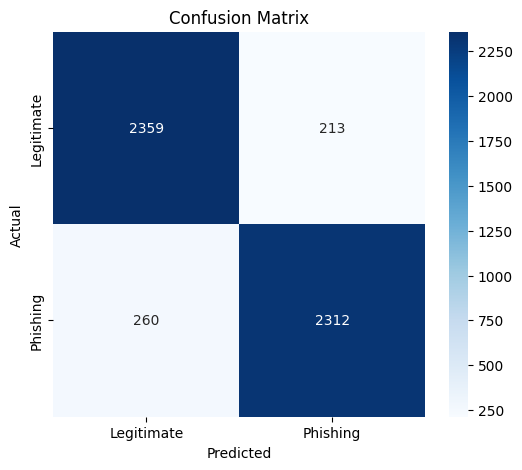

In [221]:
# Graficar Matriz de Confusión
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=['Legitimate', 'Phishing'], yticklabels=['Legitimate', 'Phishing'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Resultados de la matriz de confusión: 
- Verdaderos positivos (Phishing detectado correctamente): 2359
- Verdaderos negativos (Legitimate detectado correctamente): 2312
- Falsos positivos (Legitimate clasificado como Phishing): 213
- Falsos negativos (Phishing clasificado como Legitimate): 260


Los 260 falsos negativos significan que el modelo no detectó 260 sitios de phishing, lo cual puede ser peligroso en un entorno real. En un caso de seguridad, un FN es más crítico que un FP, porque significa que un usuario podría confiar en un sitio malicioso.

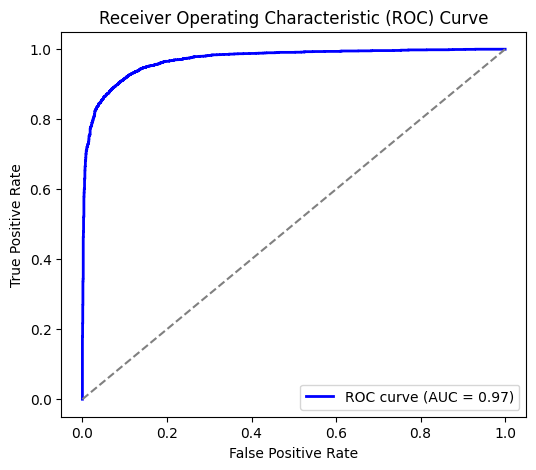

In [222]:
# Graficar Curva ROC
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [223]:
# Imprimir métricas
print("Classification Report:\n", class_report)
print(f"Area Under Curve (AUC): {roc_auc:.4f}")


Classification Report:
               precision    recall  f1-score   support

  Legitimate       0.90      0.92      0.91      2572
    Phishing       0.92      0.90      0.91      2572

    accuracy                           0.91      5144
   macro avg       0.91      0.91      0.91      5144
weighted avg       0.91      0.91      0.91      5144

Area Under Curve (AUC): 0.9703


Le fue bastante bien al modelo, con un AUC de  0.9818 y una precisión y recall equilibrados en 0.93, el SVM parece estar funcionando bien en general. Por lo que se comento anteriormente con el FN el cual en consideración del tema es elevado, se recomienda  bajar el umbral para que el modelo sea más sensible al phishing, reduciendo falsos negativos a costa de aumentar falsos positivos.

## Random Forest

In [224]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

In [225]:
# Definir X e y
X = df.drop(columns=['status','url'])  # Suponiendo que 'status' es la variable objetivo
y = df['status']

In [226]:
# Dividir los datos correctamente
test_size = 0.2  # 20% para pruebas
random_state = 42  # Para reproducibilidad
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

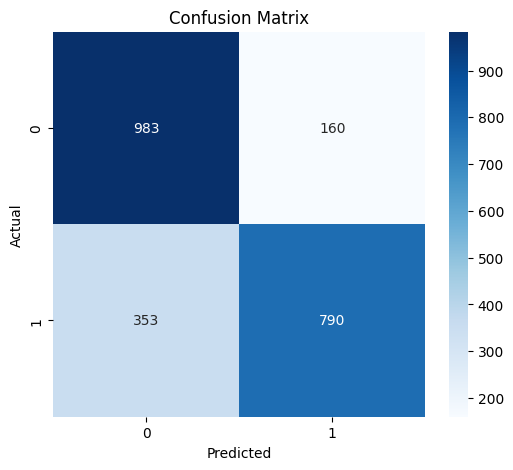

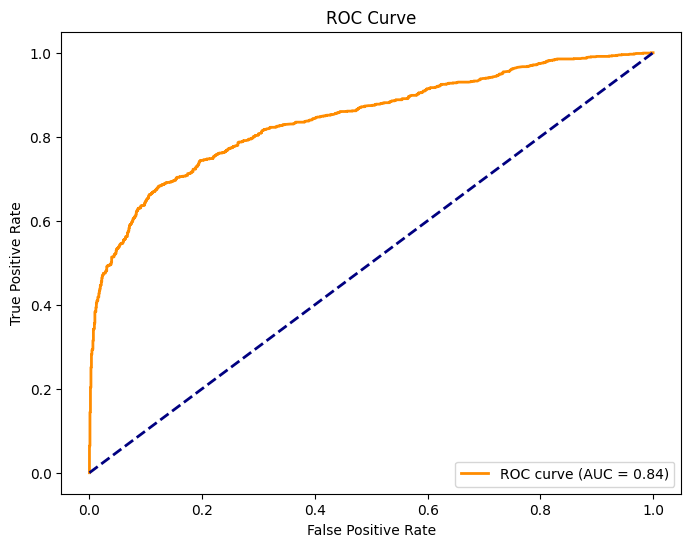

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.86      0.79      1143
           1       0.83      0.69      0.75      1143

    accuracy                           0.78      2286
   macro avg       0.78      0.78      0.77      2286
weighted avg       0.78      0.78      0.77      2286



In [227]:
#entrenar y evaluar Random Forest
random_forest_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,  # Limitar la profundidad para evitar sobreajuste
    min_samples_split=5,  # Número mínimo de muestras para dividir un nodo
    min_samples_leaf=2,  # Número mínimo de muestras en una hoja
    random_state=42
)
random_forest_model.fit(X_train, y_train)

predictions = random_forest_model.predict(X_test)
conf_matrix = confusion_matrix(y_test, predictions)
report = classification_report(y_test, predictions)
# Mostrar matriz de confusión
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Calcular y graficar la curva ROC correctamente
probs = random_forest_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

print('Classification Report:\n', report)

Resultados de la matriz de confusión: 
- Verdaderos positivos (Phishing detectado correctamente): 983
- Verdaderos negativos (Legitimate detectado correctamente): 79
- Falsos positivos (Legitimate clasificado como Phishing): 160
- Falsos negativos (Phishing clasificado como Legitimate): 353


Los 353 falsos negativos significan que el modelo no detectó 353 sitios de phishing, lo cual puede ser peligroso en un entorno real. En un caso de seguridad, un FN es más crítico que un FP, porque significa que un usuario podría confiar en un sitio malicioso.

## Discusión

4. ¿Cuál es el impacto de clasificar un sitio legítimo como phishing?
- El impacto de clasificar un sitio legítimo como phishing (falso positivo) tiene consecuencias graves que afectan tanto a empresas como usuarios. Las empresas sufren pérdidas económicas directas por transacciones bloqueadas y un significativo daño a su reputación y confianza. Los usuarios experimentan frustración al no poder acceder a servicios legítimos, lo que puede llevar a la pérdida de clientes y afectar la credibilidad del sitio a largo plazo. Además, las organizaciones deben invertir recursos adicionales en resolver estos problemas de clasificación incorrecta y restaurar la confianza de sus usuarios.


5. ¿Cuál es el impacto de clasificar un sitio de phishing como legítimo?
- El impacto de clasificar un sitio de phishing como legítimo (falso negativo) tiene consecuencias graves que afectan directamente a la seguridad de los usuarios. Los atacantes pueden robar información sensible como credenciales bancarias, números de tarjetas de crédito y datos personales, lo que puede resultar en pérdidas financieras significativas para los usuarios y las instituciones. Este error de clasificación también puede facilitar el éxito de ataques de ingeniería social, comprometer la seguridad de sistemas más amplios y dañar la confianza general en los servicios en línea. La falta de detección de sitios maliciosos puede tener un efecto cascada, permitiendo que los atacantes continúen sus actividades y afecten a más víctimas.

6. En base a las respuestas anteriores, ¿Qué métrica elegiría para comparar modelos similares de clasificación de phishing?
- Si la prioridad es reducir falsos negativos (dejar pasar phishing), usaría el recall de la clase 1 (0.69) como criterio principal. Pero si se busca un modelo balanceado, el F1-score macro (0.77) es la mejor opción.

7. ¿Qué modelo funcionó mejor para la clasificación de phishing? ¿Por qué?
- Comparando los resultados de ambos modelos, el SVM (Support Vector Machine) superó al Random Forest en todas las métricas clave:

- Accuracy: 0.91 en SVM vs. 0.78 en Random Forest.
- F1-score macro: 0.91 en SVM vs. 0.77 en Random Forest.
- Recall para phishing: 0.90 en SVM vs. 0.69 en Random Forest.
- AUC-ROC: 0.9703 en SVM vs. 0.84 en Random Forest.
- El SVM no solo tiene un mejor rendimiento general, sino que también es más confiable para detectar phishing, ya que tiene un recall más alto para la clase maliciosa (0.90 vs. 0.69). Esto significa que comete menos errores al clasificar sitios maliciosos, lo cual es fundamental en la detección de phishing.

Dado que minimizar los falsos negativos es clave en este problema, y considerando que el SVM tiene una mejor capacidad de discriminación según el AUC-ROC, este modelo es claramente la mejor opción para la clasificación de phishing.

8. Una empresa desea utilizar su mejor modelo, debido a que sus empleados sufren constantes ataques de phishing mediante e-mail. La empresa estima que, de un total de 50,000 emails, un 15% son phishing. ¿Qué cantidad de alarmas generaría su modelo? ¿Cuántas positivas y cuantas negativas? ¿Funciona el modelo para el BR propuesto? En caso negativo, ¿qué propone para reducir la cantidad de falsas alarmas?

**Cálculo de alarmas generadas por el modelo**

El modelo SVM tiene las siguientes métricas clave:

- Recall para phishing (clase positiva): 0.90 → Detecta el 90% de los correos phishing.
- Precision para phishing: 0.92 → El 92% de las detecciones positivas son realmente phishing.

Estimación de positivos y negativos:

Verdaderos positivos (VP):

- 90% de los 7,500 correos phishing serán detectados correctamente.
- VP = 7,500 × 0.90 = 6,750 correos detectados correctamente como phishing.

Falsos negativos (FN):

- 10% de los correos phishing no serán detectados.
- FN = 7,500 × 0.10 = 750 correos phishing no detectados (riesgo de ataque).

Falsos positivos (FP):

- 8% de los correos legítimos serán mal clasificados como phishing (porque Recall de legítimos = 0.92, entonces FNR = 1 - 0.92 = 0.08).
- FP = 42,500 × 0.08 = 3,400 correos legítimos mal clasificados como phishing.

Verdaderos negativos (VN):

- 92% de los correos legítimos serán correctamente clasificados.
- VN = 42,500 × 0.92 = 39,100 correos legítimos correctamente clasificados.

**¿Funciona el modelo para el BR (Base Rate) propuesto?**

El modelo genera un total de (6,750 VP + 3,400 FP) = 10,150 alertas de phishing, de las cuales 3,400 son falsas alarmas (FP). Esto significa que aproximadamente el 33.5% de las alertas serán incorrectas, lo que podría generar tension en los empleados y reducir la confianza en el sistema.

**¿Cómo reducir la cantidad de falsas alarmas?**

Para disminuir los falsos positivos sin afectar significativamente la detección de phishing, se pueden aplicar las siguientes estrategias:

- Ajustar el umbral de clasificación del modelo: Si el modelo usa probabilidad de decisión, se puede aumentar el umbral de detección para reducir los FP a costa de un ligero aumento en los FN.
- Usar un modelo híbrido: Combinar el SVM con técnicas de análisis de contenido como detección basada en reglas o análisis de lenguaje natural (NLP) para mejorar la precisión.
- Aplicar filtrado adicional: Un sistema de validación posterior (ej. revisión manual de ciertos correos sospechosos) puede reducir las falsas alarmas sin comprometer la seguridad.
- Entrenar con más datos específicos de la empresa: Si se entrena con correos internos y phishing real dirigido a la empresa, el modelo puede mejorar su discriminación.